In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import torch_geometric.transforms as T
from torch_geometric.nn import Node2Vec
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import QM7b, QM9

In [2]:
dataset_qm7b = QM7b(root='./data/QM7b')
dataset_qm9 = QM9(root='./data/QM9')

print(f'Number of graphs: {len(dataset_qm7b)}')
print(f'Number of graphs: {len(dataset_qm9)}')

Number of graphs: 7211
Number of graphs: 130831


Data(edge_index=[2, 256], edge_attr=[256], y=[1, 14], num_nodes=16)
tensor([[-1.5874e+03,  6.5508e+00,  2.1294e-01, -1.0490e+01,  5.2600e-01,
          5.4837e+00,  9.9777e+00,  1.1418e-01, -7.2957e+00, -1.7860e-01,
         -9.3775e+00,  1.4591e+00,  1.1219e+01,  1.2055e+01]])
tensor([53.3587,  1.7890,  0.8501,  1.4097,  6.2905,  1.0771,  1.9720,  1.1776,
         0.7545,  0.7835,  1.0648,  7.5393, 20.8563, 17.3357,  5.4054,  9.2181,
         1.7890,  0.5000,  0.1557,  0.1382,  1.0315,  0.1681,  0.1595,  0.2071,
         0.1092,  0.1042,  0.1237,  0.8748,  1.7792,  2.8847,  0.7454,  1.4193,
         0.8501,  0.1557,  0.5000,  0.1398,  2.8902,  0.2954,  0.0867,  0.2130,
         0.2100,  0.1778,  0.1339,  1.0146,  0.7911,  0.9734,  1.3873,  1.3842,
         1.4097,  0.1382,  0.1398,  0.5000,  1.1732,  0.1883,  0.1270,  0.1720,
         0.1709,  0.2098,  0.2962,  2.8911,  1.0598,  1.1483,  1.4345,  1.4482,
         6.2905,  1.0315,  2.8902,  1.1732, 36.8581,  2.8874,  0.5979,  1.4517,
 

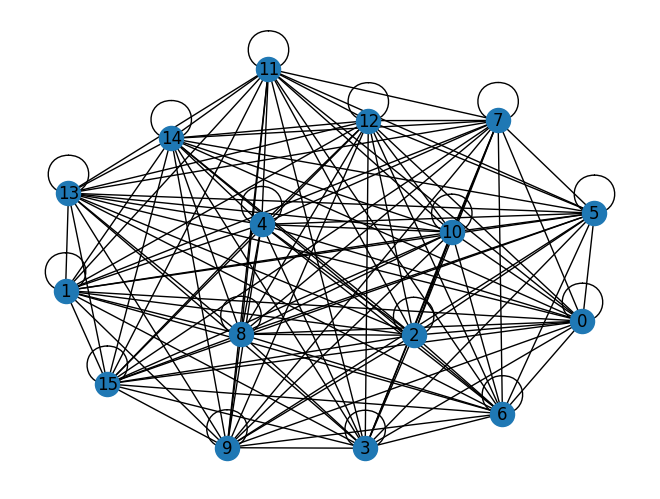

In [24]:
i = 6840

print(dataset_qm7b[i])
print(dataset_qm7b[i].y)
print(dataset_qm7b[i].edge_attr)

g = to_networkx(dataset_qm7b[i], to_undirected=True)
nx.draw(g, with_labels=True)

In [3]:
length = len(dataset_qm7b)
idx = np.random.permutation(length)
train_idx = idx[:int(0.8*length)]
val_idx = idx[int(0.8*length):int(0.9*length)]
test_idx = idx[int(0.9*length):]

train = [dataset_qm7b[i] for i in train_idx]
val = [dataset_qm7b[i] for i in val_idx]
test = [dataset_qm7b[i] for i in test_idx]

print(f'Train: {len(train)} Val: {len(val)} Test: {len(test)}')


Train: 5768 Val: 721 Test: 722


In [4]:
def create_combined_graph(graph_dataset):
    combined_edge_index = []
    batch_indicators = []
    node_features = []
    offset = 0
    
    for i, data in enumerate(graph_dataset):
        # Add edges with offset node indices
        edges = data.edge_index + offset
        combined_edge_index.append(edges)
        
        # Track which nodes belong to which graph
        batch_indicators.extend([i] * data.num_nodes)
        
        # Store node features if they exist
        if hasattr(data, 'x') and data.x is not None:
            node_features.append(data.x)
        
        # Update offset for next graph
        offset += data.num_nodes
    
    # Concatenate all edges
    combined_edge_index = torch.cat(combined_edge_index, dim=1)
    
    # Concatenate node features if they exist
    if node_features:
        combined_node_features = torch.cat(node_features, dim=0)
    else:
        combined_node_features = None
    
    return combined_edge_index, torch.tensor(batch_indicators), combined_node_features

torch.Size([2, 1410204]) torch.Size([88840])


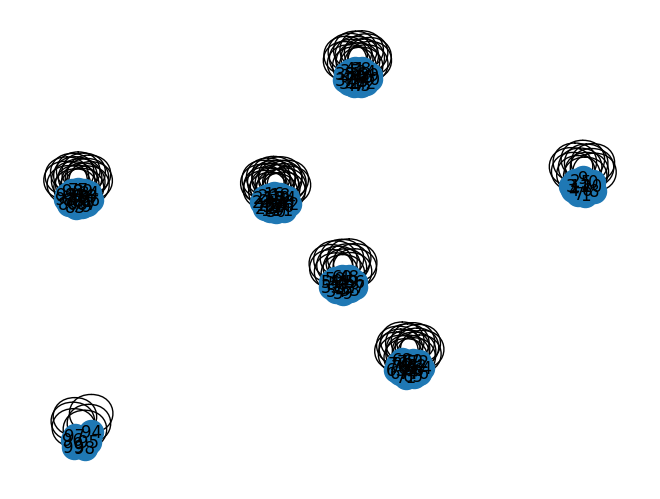

In [23]:
combined_edge_index, batch_indicators, combined_node_features = create_combined_graph(train)
print(combined_edge_index.shape, batch_indicators.shape)

combined_graph = Data(edge_index=combined_edge_index, x=combined_node_features, batch=batch_indicators)
small_g = to_networkx(combined_graph, to_undirected=True).subgraph(range(100))
nx.draw(small_g, with_labels=True)

In [5]:
def get_graph_embeddings(node_embeddings, batch_indicators, num_graphs):
    graph_embeddings = []
    for i in range(num_graphs):
        # Get embeddings for nodes in this graph
        mask = batch_indicators == i
        graph_node_embeddings = node_embeddings[mask]
        
        # Aggregate (mean pooling)
        graph_emb = graph_node_embeddings.mean(dim=0)
        graph_embeddings.append(graph_emb)
    
    return torch.stack(graph_embeddings)


In [49]:
def get_embeddings_for_graphs(graph_dataset, epochs, config):
    edge_index, batch, x = create_combined_graph(graph_dataset)
    
    model = Node2Vec(
        edge_index=edge_index,
        embedding_dim=config['embedding_dim'],
        walk_length=config['walk_length'],
        context_size=config['context_size'],
        walks_per_node=config['walks_per_node'],
        num_negative_samples=config['num_negative_samples'],
        p=config['p'],
        q=config['q'],
        sparse = False
    ).to(device)
    
    loader = model.loader(batch_size=256, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    model.train()
    for epoch in range(1, epochs+1):
        total_loss = 0
        for pos_rw, neg_rw in loader:
            optimizer.zero_grad()
            loss = model.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch: {epoch:02d}, Loss: {total_loss/len(loader):.4f}')
    
    # Get embeddings
    model.eval()
    with torch.no_grad():
        node_embeddings = model()
    
    # Convert to graph embeddings
    graph_embeddings = get_graph_embeddings(node_embeddings, batch, len(graph_dataset))
    
    return graph_embeddings


config = {
    'embedding_dim': 64,
    'walk_length': 10,
    'context_size': 5,
    'walks_per_node': 10,
    'num_negative_samples': 1,
    'p': 0.6,
    'q': 2.0
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Train')
x_train = get_embeddings_for_graphs(train, 10, config)
print('Val')
x_val = get_embeddings_for_graphs(val, 30, config)
print('Test')
x_test = get_embeddings_for_graphs(test, 30, config)


Train
Epoch: 01, Loss: 3.7859
Epoch: 02, Loss: 1.9668
Epoch: 03, Loss: 1.3929
Epoch: 04, Loss: 1.0757
Epoch: 05, Loss: 0.9180
Epoch: 06, Loss: 0.8422
Epoch: 07, Loss: 0.8039
Epoch: 08, Loss: 0.7842
Epoch: 09, Loss: 0.7739
Epoch: 10, Loss: 0.7693
Val
Epoch: 01, Loss: 5.1695
Epoch: 02, Loss: 3.2778
Epoch: 03, Loss: 2.5634
Epoch: 04, Loss: 2.2127
Epoch: 05, Loss: 1.9452
Epoch: 06, Loss: 1.7203
Epoch: 07, Loss: 1.5331
Epoch: 08, Loss: 1.3770
Epoch: 09, Loss: 1.2503
Epoch: 10, Loss: 1.1507
Epoch: 11, Loss: 1.0714
Epoch: 12, Loss: 1.0078
Epoch: 13, Loss: 0.9572
Epoch: 14, Loss: 0.9184
Epoch: 15, Loss: 0.8878
Epoch: 16, Loss: 0.8631
Epoch: 17, Loss: 0.8443
Epoch: 18, Loss: 0.8275
Epoch: 19, Loss: 0.8148
Epoch: 20, Loss: 0.8043
Epoch: 21, Loss: 0.7963
Epoch: 22, Loss: 0.7889
Epoch: 23, Loss: 0.7836
Epoch: 24, Loss: 0.7777
Epoch: 25, Loss: 0.7741
Epoch: 26, Loss: 0.7696
Epoch: 27, Loss: 0.7666
Epoch: 28, Loss: 0.7636
Epoch: 29, Loss: 0.7612
Epoch: 30, Loss: 0.7597
Test
Epoch: 01, Loss: 5.1893
E

In [50]:
x_train = x_train.detach()
x_val = x_val.detach()
x_test = x_test.detach()

y_train = torch.stack([data.y for data in train]).squeeze().to(device)
y_val = torch.stack([data.y for data in val]).squeeze().to(device)
y_test = torch.stack([data.y for data in test]).squeeze().to(device)

print(x_train.shape, y_train.shape)
print(x_train.device, y_train.device)


torch.Size([5768, 64]) torch.Size([5768, 14])
cuda:0 cuda:0


In [37]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error

class MultiTargetMLP(nn.Module):
    def __init__(self, input_dim=config['embedding_dim'], hidden_dims=[64, 128, 64], output_dim=14):
        super(MultiTargetMLP, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(dim))
            layers.append(nn.Dropout(0.2))
            prev_dim = dim
            
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)


In [51]:
# Create dataset and dataloader
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Initialize model and optimizer
model = MultiTargetMLP(input_dim=x_train.shape[1], output_dim=y_train.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

# Training loop
n_epochs = 500
best_val_mse = float('inf')
patience = 50
counter = 0

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(x_val)
        val_loss = criterion(val_outputs, y_val).item()
    
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val MSE: {val_loss:.4f}")
    
    # Early stopping
    if val_loss < best_val_mse:
        best_val_mse = val_loss
        counter = 0
        # Save model
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model and evaluate on test set
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
    test_preds = model(x_test).cpu().numpy()
    test_mse = mean_squared_error(y_test.cpu().numpy(), test_preds)
    print(f"Test MSE with MLP: {test_mse:.4f}")

Epoch 1/500, Train Loss: 177982.7089, Val MSE: 176913.6250
Epoch 2/500, Train Loss: 178844.8003, Val MSE: 176722.2500
Epoch 3/500, Train Loss: 178086.8186, Val MSE: 176459.3750
Epoch 4/500, Train Loss: 177490.5007, Val MSE: 176057.5938
Epoch 5/500, Train Loss: 177813.5041, Val MSE: 175479.0781
Epoch 6/500, Train Loss: 176691.4351, Val MSE: 174553.4062
Epoch 7/500, Train Loss: 175454.8084, Val MSE: 173832.3906
Epoch 8/500, Train Loss: 174220.8091, Val MSE: 172617.2031
Epoch 9/500, Train Loss: 173545.3278, Val MSE: 171237.7812
Epoch 10/500, Train Loss: 171649.5136, Val MSE: 170148.1875
Epoch 11/500, Train Loss: 170164.9378, Val MSE: 168374.5625
Epoch 12/500, Train Loss: 168844.1804, Val MSE: 167270.0156
Epoch 13/500, Train Loss: 166964.0319, Val MSE: 165678.2344
Epoch 14/500, Train Loss: 164778.3122, Val MSE: 162688.1719
Epoch 15/500, Train Loss: 163075.6216, Val MSE: 160858.7656
Epoch 16/500, Train Loss: 161315.8889, Val MSE: 159073.0312
Epoch 17/500, Train Loss: 158450.0187, Val MSE: 1

C:\Users\wittd\AppData\Local\Temp\ipykernel_18816\2236278886.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))
